#Подключаем библиотеки и импортируем данные




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import data_table
data_table.enable_dataframe_formatter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = [
    'Возраст',
    'Количество иждевенцев',
    'Доход(руб./мес.)',
    'Срок проживания(лет)',
    'Оценка автомобиля(USD)',
    'Размер кредита(тыс.руб.)'
    ]

data_raw = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab/22MAG_HW_1_v6.csv', header=None, names=labels))

In [ ]:
data_raw.head()

,Возраст,Количество иждевенцев,Доход(руб./мес.),Срок проживания(лет),Оценка автомобиля(USD),Размер кредита(тыс.руб.)
0,51.0,3.0,17600.0,17.0,20000.0,190000.0
1,40.0,2.0,NaN,10.0,13000.0,127000.0
2,51.0,3.0,7100.0,17.0,9000.0,82000.0
3,NaN,2.0,16000.0,13.0,17000.0,165000.0
4,49.0,3.0,14900.0,16.0,17000.0,159000.0


#Первичная обработка данных

##1. Осмотр данных.

**Основные характеристики данных.**

In [ ]:
data_raw.describe()

,Возраст,Количество иждевенцев,Доход(руб./мес.),Срок проживания(лет),Оценка автомобиля(USD),Размер кредита(тыс.руб.)
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,38.512821,1.974359,19600.000000,10.487179,20846.153846,205846.153846
std,8.855185,1.038399,9682.077854,4.849698,11868.885598,98675.315119
min,19.000000,0.000000,700.000000,1.000000,0.000000,3000.000000
25%,31.500000,1.000000,15150.000000,6.500000,14500.000000,162000.000000
50%,39.000000,2.000000,20200.000000,11.000000,20000.000000,207000.000000
75%,44.000000,3.000000,26600.000000,13.000000,27000.000000,269000.000000
max,56.000000,4.000000,38600.000000,20.000000,50000.000000,397000.000000


**Гистограммы признаков**

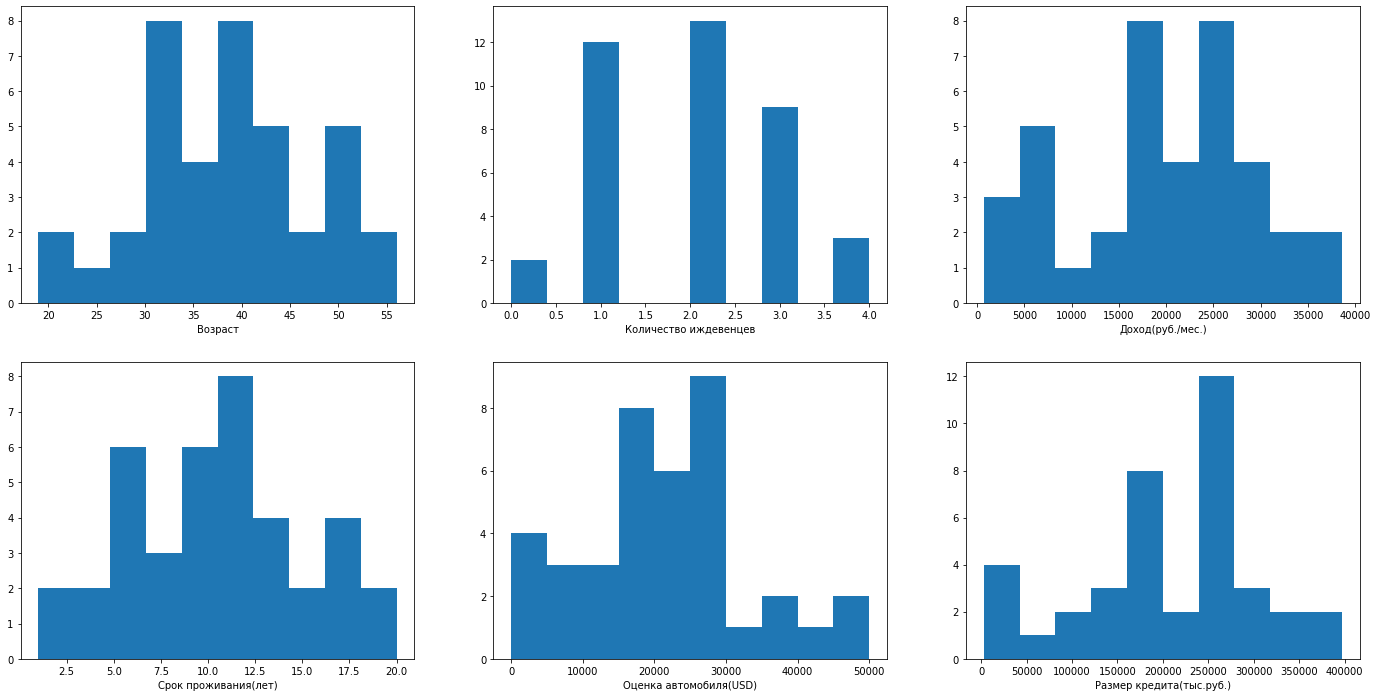

In [ ]:
plt.figure(figsize=(24, 12))
for i, col in enumerate(data_raw.columns):
  plt.subplot(2, 3, i+1)
  plt.hist(data_raw[col])
  plt.xlabel(col)
plt.show()

**Ящик с усами**

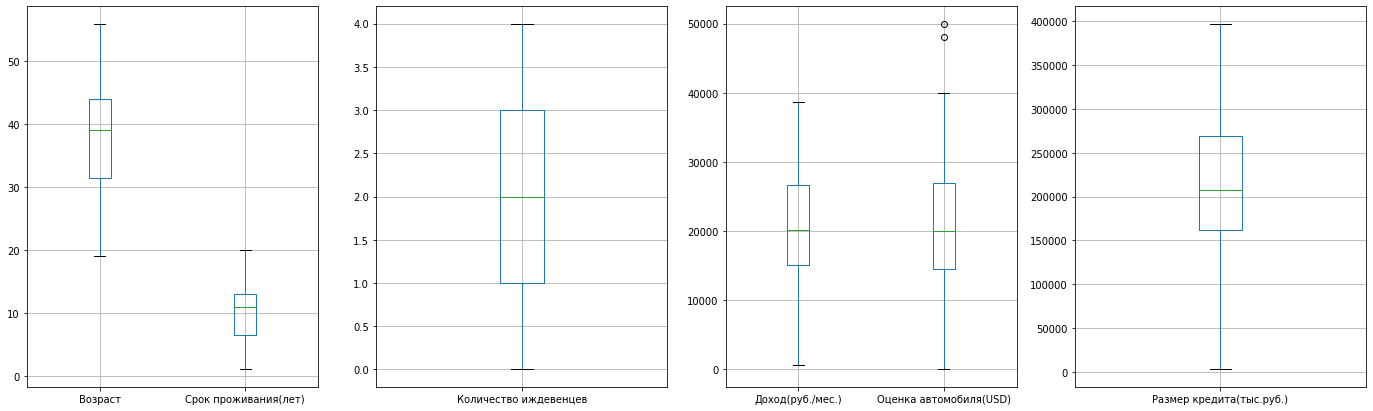

In [ ]:
plt.figure(figsize=(24, 7))
for i, col in enumerate([['Возраст',  'Срок проживания(лет)'], ['Количество иждевенцев'], ['Доход(руб./мес.)',  'Оценка автомобиля(USD)'], ['Размер кредита(тыс.руб.)']]):
  plt.subplot(1, 4, i+1)
  data_raw.boxplot(column = col).plot()
plt.show()

Распределения дохода, оценки автомобиля и размера кредита похожи. Также похожи распределения возраста и срока проживания.

Можно заметить выбросы в оценке автомобиля.

##2. Восстановление пропусков.

Восстанавливаем признаки с помощью баесовской линейной регрессии.

Сначала пропуски заполняются медианой, потом на всём датасете обучается линейная регрессия, и дальше она заполняет пропуски уже своими предсказаниями с некоторой нормально распределёной ошибкой.

In [ ]:
Imputer = IterativeImputer(random_state=0)
Imputer.fit(data_raw)
np_data_without_na = Imputer.transform(data_raw)
data_without_na = pd.DataFrame(np_data_without_na, columns=data_raw.columns)

Мы потеряли категориальность некоторых признаков. Кроме того, значения некоторых признаков(например дохода) были кратны 1000. Мы могли бы привести данные к такому виду, что добавило бы некоторую случайность в заполненые пропуски.
Но во-первых, мы уже добавили ошибку и дополнительная случайность может быть избыточной, а во-вторых, наши данные далее будут нормализованы, поэтому в этом нет особого смысла.

##3. Удаление выбросов.

Поскольку данных немного, все выбросы можно увидеть по "ящику с усами" из пункта 1.

Удаляем выбросы.

In [ ]:
data_without_outlier = data_without_na.loc[data_without_na['Оценка автомобиля(USD)'] < 45000]

#Метод PCA

##4. Централизация и нормализация.

Выполняем центрирование данных.

In [ ]:
data_centered = data_without_outlier.apply(lambda x: x - x.mean())
data_centered.head(3)

,Возраст,Количество иждевенцев,Доход(руб./мес.),Срок проживания(лет),Оценка автомобиля(USD),Размер кредита(тыс.руб.)
0,10.963451,1.032988,-2379.984013,6.934156,22.871912,-10083.500976
1,-0.036549,0.032988,-7404.050505,-0.065844,-6977.128088,-73083.500976
2,10.963451,1.032988,-12879.984013,6.934156,-10977.128088,-118083.500976


Выполняем нормировку.

In [ ]:
data = data_centered.apply(lambda x: x/np.sqrt(np.sum(np.square(x))))
data.head(3)

,Возраст,Количество иждевенцев,Доход(руб./мес.),Срок проживания(лет),Оценка автомобиля(USD),Размер кредита(тыс.руб.)
0,0.219035,0.157057,-0.038250,0.223238,0.000366,-0.016166
1,-0.000730,0.005016,-0.118994,-0.002120,-0.111498,-0.117167
2,0.219035,0.157057,-0.207000,0.223238,-0.175420,-0.189310


##5. SVD разложение.

Находим SVD разложение матрицы $Z = USV^T$.

In [ ]:
Z = data.to_numpy()
U, S, V = np.linalg.svd(Z, full_matrices = False)
print('Сингулярные числа:', S)

Сингулярные числа: [1.8110584  1.63382867 0.21815324 0.04554977 0.02956165 0.011483  ]


##6. Скрытые факторы.

Сингулярные чила и их вклады в вариацию данных(в %)

In [ ]:
pd.DataFrame([[round(i, 3) for i in S], [round(100*(i)**2/np.sum(np.square(S)), 3) for i in S]], index=['sv', '%'])

,0,1,2,3,4,5
sv,1.811,1.634,0.218,0.046,0.030,0.011
%,54.666,44.490,0.793,0.035,0.015,0.002


Заметим, что 2 главных фактора вносят более 99% вариации данных.

Таким образом, относительная ошибка аппроксимации матрицами ранга 2 в норме Фробениуса меньше 1%.



In [ ]:
print(100 * (np.sum(np.square(S[2:]))/np.sum(np.square(S))),'%')

0.8445227913270398 %


Относительная ошибка аппроксимации матрицами ранга 2 в спектральной евклидовой норме.

In [ ]:
print(100 * S[2]/S[0],'%')

12.045621401868514 %


Отсюда можно сделать вывод, что главных фактора два.

##7. Карта клиентов.

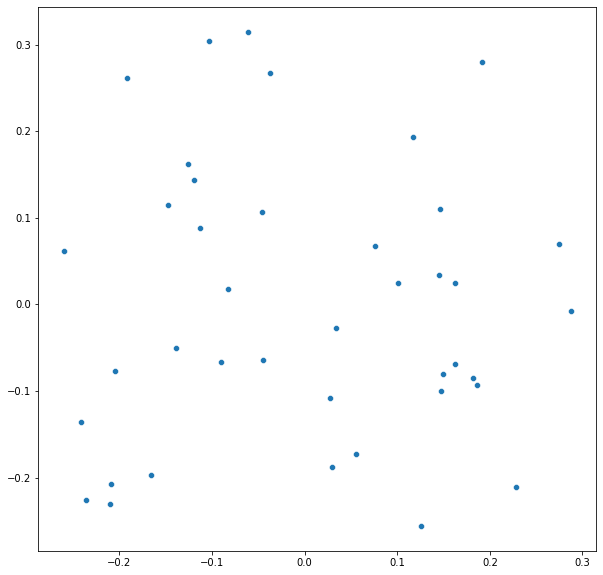

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=U[:, 0], y=U[:, 1])
plt.show()

Трудно сделать какой-либо вывод по этой карте клиентов.
Можно сказать, что у банка достаточно разные клиенты :)

##8, 9. Интерпритация главных факторов.



Выпишем разложения признаков $z^j$.

In [ ]:
print(*[f'z^{i} = {round(S[0] * V[0, i],2)} * u_1 + {round(S[1] * V[1, i],2)} * u_2  //' + data.columns[i] for i in range(len(S))], sep='\n')

z^0 = -0.67 * u_1 + 0.74 * u_2  //Возраст
z^1 = -0.36 * u_1 + 0.92 * u_2  //Количество иждевенцев
z^2 = 0.9 * u_1 + 0.44 * u_2  //Доход(руб./мес.)
z^3 = -0.72 * u_1 + 0.68 * u_2  //Срок проживания(лет)
z^4 = 0.81 * u_1 + 0.59 * u_2  //Оценка автомобиля(USD)
z^5 = 0.85 * u_1 + 0.53 * u_2  //Размер кредита(тыс.руб.)


Так же для интерпритации признаков можно обратить внимание на матрицу корреляции.

In [ ]:
data.corr()

,Возраст,Количество иждевенцев,Доход(руб./мес.),Срок проживания(лет),Оценка автомобиля(USD),Размер кредита(тыс.руб.)
Возраст,1.000000,0.902999,-0.269962,0.994667,-0.103639,-0.173547
Количество иждевенцев,0.902999,1.000000,0.079054,0.871774,0.238271,0.173060
Доход(руб./мес.),-0.269962,0.079054,1.000000,-0.346696,0.984918,0.994974
Срок проживания(лет),0.994667,0.871774,-0.346696,1.000000,-0.183792,-0.252541
Оценка автомобиля(USD),-0.103639,0.238271,0.984918,-0.183792,1.000000,0.996840
Размер кредита(тыс.руб.),-0.173547,0.173060,0.994974,-0.252541,0.996840,1.000000


Не трудно заметить, что признаки 'Возраст', 'Количество иждевенцев' и 'Срок проживания' сильно кореллируют между собой, остальные признаки также можно объединить в один. Таким образом, главными факторами являются: $u_1$ - это финансовое положение объекта, а $u_2$ - уровень оседлости.

#Метод MDS.

## 10. Матрица расстояний.

Будем использовать евклидову метрику.

Строим матрицу расстояний $D$.

In [ ]:
X = data.to_numpy()
D = distance_matrix(X, X)

## 11. "Чистый" MDS.

Строим матрицу $S = -\frac{1}{2}(E_n - \frac{J_n}{n})D^2 (E_n - \frac{J_n}{n})$, где $E_n$ -единичная матрица, а $J_n$ - матрица из единиц.


In [ ]:
n = D.shape[0]
C = np.eye(n) - (np.ones((n, n))/n)
S = (-1/2)*np.dot(np.dot(C, np.square(D)), C)

Находим все собственные значения матрицы $S$.

In [ ]:
eig_values = np.around(np.linalg.eigvalsh(S), 14)[::-1]
print(eig_values)

[ 3.27993252e+00  2.66939611e+00  4.75908352e-02  2.07478150e-03
  8.73891392e-04  1.31859338e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]


В данной матрице только 6 ненулевых значений, кроме того, они неотрицательны


In [ ]:
np.all(np.around(np.linalg.eigvalsh(S), 14)[::-1] >= 0)

True

Поэтому можно сказать, что вложить клиентов банка в пространство меньшей размерности нельзя.

## 12. MDS с ошибкой.

Воспользуемся реализованным алгоритмом MDS. Сначал найдём размерность с наименьшим значением "стресса".

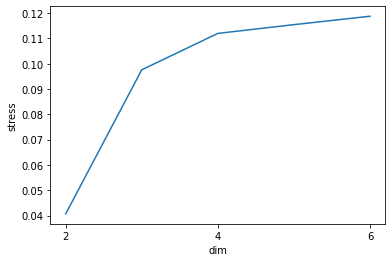

In [ ]:
stress = []
for dim in range(2, 7):
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=554, max_iter=1000)
    pts = mds.fit_transform(D)
    stress.append(mds.stress_)

plt.plot(range(2, 7), stress)
plt.xticks(range(2, 7, 2))
plt.xlabel('dim')
plt.ylabel('stress')
plt.show()

Видно, что лучше всего подходит размерность 2. А для размерности 1 "стресс" на несколько порядков больше.

In [ ]:
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=554, max_iter=1000)
pts = mds.fit_transform(D)
mds.stress_

57.03501381938833

Ещё раз обучим MDS для размерности 2.

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=554, max_iter=1000)
pts = mds.fit_transform(D)

Построим новую карту клиентов.

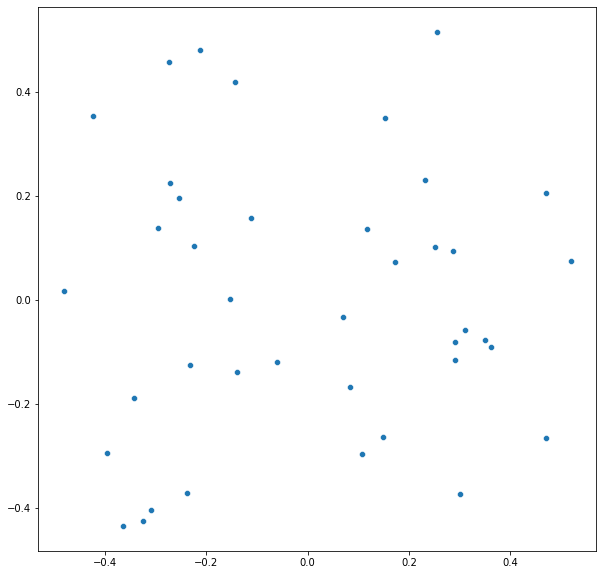

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pts[:, 1], y=(-1)*pts[:, 0])
plt.show()

С помощью метода пристального взгляда можно заметить, что она незначительно отличается от карты построенной с помощью PCA.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Копия_блокнота__Homework1_ipynb_.ipynb

[NbConvertApp] Converting notebook /content/Копия_блокнота__Homework1_ipynb_.ipynb to html
[NbConvertApp] Writing 450276 bytes to /content/Копия_блокнота__Homework1_ipynb_.html
